In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

In [2]:
a = pd.read_csv('olist_customers_dataset.csv')

In [3]:
b = pd.read_csv('olist_order_items_dataset.csv')

In [4]:
c = pd.read_csv('olist_orders_dataset.csv')

In [5]:
abc = a.merge(c, on = 'customer_id').merge(b, on = 'order_id')

In [6]:
# Liste der Datums-Spalten
date_columns = [
    'order_purchase_timestamp', 'order_approved_at', 
    'order_delivered_carrier_date', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'shipping_limit_date'
]

# Ersetzen von fehlenden Werten in den angegebenen Spalten durch 0
abc[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']] = abc[
    ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']
].fillna(0)

In [7]:
# Anzeige der ersten 5 Zeilen des DataFrames
print("Die ersten 5 Zeilen des DataFrames:")
print(abc.head())

# Anzeige von Informationen über den DataFrame (Datenart, Anzahl der Nicht-Null-Werte, etc.)
print("\nInformationen über den DataFrame:")
print(abc.info())

# Überprüfung auf fehlende Werte in jedem Feld des DataFrames
print("\nFehlende Werte:")
print(abc.isnull().sum())

# Anzahl der doppelten Zeilen im DataFrame
print("\nAnzahl der Duplikate:")
print(abc.duplicated().sum())

# Statistik der numerischen Spalten (Mittelwert, Standardabweichung, Min, Max, etc.)
print("\nStatistik der numerischen Spalten:")
print(abc.describe())

# Verteilung der kategorialen Variablen (Anzahl der Vorkommen jeder Kategorie)
print("\nVerteilung der kategorialen Variablen:")
for column in abc.select_dtypes(include='object').columns:
    print(f"\n{column}:")
    print(abc[column].value_counts())

# Liste der Datums-Spalten
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date']

# Umwandlung der angegebenen Datums-Spalten in das Datetime-Format
abc[date_columns] = abc[date_columns].apply(pd.to_datetime, errors='coerce')

# Ersetzen von fehlenden Werten in den angegebenen Datums-Spalten durch 0
abc[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']] = abc[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].fillna(0)

# Anzeige der ersten 5 Zeilen des DataFrames nach der Umwandlung
print(abc.head())

Die ersten 5 Zeilen des DataFrames:
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297

# Überblick über den DataFrame

Der DataFrame enthält Informationen über 112.650 Bestellungen.

## Fehlende Werte

Es gibt keine fehlenden Werte in den Daten (korrigiert).

## Durchschnittswerte

- Eine durchschnittliche Bestellung enthält ungefähr 1,2 Produkteinheiten.
- Der durchschnittliche Produktpreis beträgt etwa 120,65.
- Die durchschnittlichen Versandkosten betragen etwa 19,99.

## Mindest- und Höchstwerte

- Der Mindestproduktpreis beträgt 0,85.
- Der Höchstpreis beträgt 6.735.
- Die minimalen Versandkosten betragen 0,00.
- Die maximalen Versandkosten betragen 409,68.

## Bestellstatus

- Die meisten Bestellungen wurden geliefert (**order_status: delivered**).

## Häufigste Werte

- Die häufigste Kundenstadt ist **São Paulo**.
- Der am häufigsten vertretene Kundenstaat ist **SP (São Paulo)**.

## Produkte

- Die meisten Produkte haben eindeutige Kennungen.
- Die Spalte **order_item_id** hat einen Mittelwert nahe 1, was darauf hinweist, dass die meisten Bestellungen ein Produkt enthalten.
- Die Bestellstatus in der Spalte **order_status** zeigen, dass die meisten Bestellungen geliefert wurden.
- Es gibt Produkte, die am häufigsten gekauft werden (z. B. **"aca2eb7d00ea1a7b8ebd4e68314663af"** mit 527 Käufen).

## 1. Anzahl der einzigartigen Bestellungen pro Benutzer. Auswahl und Ausgabe der Benutzer, die nur eine Bestellung aufgegeben haben.

In [8]:
# Berechnung der Anzahl einzigartiger Bestellungen für jeden Benutzer
purchase_count = abc.groupby('customer_unique_id')['order_id'].nunique()

# Filterung der Benutzer, die nur eine Bestellung aufgegeben haben
single_purchase_users = purchase_count[purchase_count == 1]

# Ausgabe der Anzahl der Benutzer mit nur einer Bestellung
print("Anzahl der Benutzer mit einer Bestellung:", len(single_purchase_users))

Anzahl der Benutzer mit einer Bestellung: 92507


## 2. Wie viele Bestellungen werden durchschnittlich pro Monat aus verschiedenen Gründen nicht zugestellt (Details nach Gründen anzeigen)?

In [9]:
# Umwandlung der 'order_purchase_timestamp'-Spalte in das Datetime-Format
abc['order_purchase_timestamp'] = pd.to_datetime(abc['order_purchase_timestamp'])

# Umwandlung der 'order_delivered_customer_date'-Spalte in das Datetime-Format und Behandlung von Fehlern
abc['order_delivered_customer_date'] = pd.to_datetime(abc['order_delivered_customer_date'], errors='coerce')

# Erstellen einer neuen Spalte 'purchase_month' mit dem Monat der Bestellung
abc['purchase_month'] = abc['order_purchase_timestamp'].dt.to_period('M')

# Filtern der Bestellungen, die nicht zugestellt wurden
undelivered_orders = abc[abc['order_status'].isin(['unavailable', 'canceled'])]

# Gruppierung nach Monat und Bestellstatus und Zählen der Anzahl der Bestellungen
undelivered_counts = undelivered_orders.groupby(['purchase_month', 'order_status'])['order_id'].count()

# Ausgabe der Anzahl der nicht zugestellten Bestellungen nach Monat und Status
print(undelivered_counts)

# Berechnung der durchschnittlichen Anzahl der nicht zugestellten Bestellungen pro Monat
average_undelivered_per_month = undelivered_counts.groupby('purchase_month').mean()

# Ausgabe des Durchschnitts der nicht zugestellten Bestellungen pro Monat
print("Durchschnittliche Anzahl der nicht zugestellten Bestellungen pro Monat:")
print(average_undelivered_per_month)

purchase_month  order_status
2016-09         canceled         1
2016-10         canceled        14
                unavailable      7
2017-01         canceled         2
2017-02         canceled        15
2017-03         canceled        25
2017-04         canceled        24
2017-05         canceled        30
2017-06         canceled        12
2017-07         canceled        26
2017-08         canceled        28
2017-09         canceled        16
2017-10         canceled        22
2017-11         canceled        39
2017-12         canceled         8
2018-01         canceled        35
2018-02         canceled        75
2018-03         canceled        22
2018-04         canceled        18
2018-05         canceled        27
2018-06         canceled        18
2018-07         canceled        53
2018-08         canceled        32
Name: order_id, dtype: int64
Durchschnittliche Anzahl der nicht zugestellten Bestellungen pro Monat:
purchase_month
2016-09     1.0
2016-10    10.5
2017-01     2.0
20

## 3. Für jedes Produkt bestimmen, an welchem Wochentag das Produkt am häufigsten gekauft wird.

In [10]:
# Umwandlung der Spalte 'order_purchase_timestamp' in das Datetime-Format
abc['order_purchase_timestamp'] = pd.to_datetime(abc['order_purchase_timestamp'])

# Extraktion des Wochentags aus dem Datum (0=Mo, 1=Di, ..., 6=So)
abc['purchase_day_of_week'] = abc['order_purchase_timestamp'].dt.dayofweek

# Definition der Wochentage als Strings
wochentage = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So']

# Filtern der abgeschlossenen Bestellungen (angenommen, dass 'delivered' ein relevanter Status ist)
# Hier müssen Sie den spezifischen Status Ihrer abgeschlossenen Bestellungen anpassen
completed_orders = abc[abc['order_status'] == 'delivered']

# Bestimmung der häufigsten Wochentage für jedes Produkt (beachten Sie mehrere mögliche Tage)
häufigster_kauf_tag = completed_orders.groupby('product_id')['purchase_day_of_week'].agg(lambda x: list(x.mode()))

# Ersetzung der Zahlen durch die Namen der Wochentage (Mehrere mögliche Tage)
häufigster_kauf_tag = häufigster_kauf_tag.map(lambda x: [wochentage[day] for day in x])

# Ausgabe der Ergebnisse
print(häufigster_kauf_tag)

product_id
00066f42aeeb9f3007548bb9d3f33c38        [So]
00088930e925c41fd95ebfe695fd2655        [Di]
0009406fd7479715e4bef61dd91f2462        [Do]
000b8f95fcb9e0096488278317764d19    [Mi, Fr]
000d9be29b5207b54e86aa1b1ac54872        [Di]
                                      ...   
fff6177642830a9a94a0f2cba5e476d1    [Sa, So]
fff81cc3158d2725c0655ab9ba0f712c        [Mo]
fff9553ac224cec9d15d49f5a263411f        [Fr]
fffdb2d0ec8d6a61f0a0a0db3f25b441        [Di]
fffe9eeff12fcbd74a2f2b007dde0c58        [Mi]
Name: purchase_day_of_week, Length: 32216, dtype: object


## 4. Wie viele Einkäufe hat jeder Benutzer durchschnittlich pro Woche (nach Monaten)?


In [11]:
# Umwandlung der Spalte 'order_purchase_timestamp' in das Datetime-Format
abc['order_purchase_timestamp'] = pd.to_datetime(abc['order_purchase_timestamp'])

# Extraktion des Monats aus dem Datum
abc['purchase_month'] = abc['order_purchase_timestamp'].dt.to_period('M')

# Filtern der abgeschlossenen Bestellungen (angenommen, dass 'delivered' ein relevanter Status ist)
completed_orders = abc[abc['order_status'] == 'delivered']

# Gruppierung nach Kunde und Monat und Anzahl der einzigartigen Bestellungen im Monat
user_purchase_stats = completed_orders.groupby(['customer_unique_id', 'purchase_month']).agg({'order_id': 'nunique'}).reset_index()

# Berechnung der Anzahl der Tage im Monat
user_purchase_stats['days_in_month'] = user_purchase_stats['purchase_month'].dt.days_in_month

# Berechnung der Anzahl der Wochen im Monat
def calculate_weeks_in_month(period, days_in_month):
    # Berechnung des ersten und letzten Tages des Monats
    start_date = period.start_time
    end_date = period.end_time
    
    # Überprüfung, ob der letzte Tag des Monats unvollständig ist
    if end_date.day != days_in_month:
        end_date = end_date.replace(day=days_in_month)
    
    # Berechnung der Anzahl der vollen Wochen
    total_days = (end_date - start_date).days + 1
    weeks = total_days / 7
    
    return weeks

user_purchase_stats['weeks_in_month'] = user_purchase_stats.apply(
    lambda row: calculate_weeks_in_month(row['purchase_month'], row['days_in_month']),
    axis=1
)

# Berechnung der durchschnittlichen Anzahl der Bestellungen pro Woche
user_purchase_stats['avg_orders_per_week'] = user_purchase_stats['order_id'] / user_purchase_stats['weeks_in_month']

# Ausgabe der Ergebnisse
print(user_purchase_stats[['customer_unique_id', 'purchase_month', 'avg_orders_per_week']])

                     customer_unique_id purchase_month  avg_orders_per_week
0      0000366f3b9a7992bf8c76cfdf3221e2        2018-05             0.225806
1      0000b849f77a49e4a4ce2b2a4ca5be3f        2018-05             0.225806
2      0000f46a3911fa3c0805444483337064        2017-03             0.225806
3      0000f6ccb0745a6a4b88665a16c9f078        2017-10             0.225806
4      0004aac84e0df4da2b147fca70cf8255        2017-11             0.233333
...                                 ...            ...                  ...
95189  fffcf5a5ff07b0908bd4e2dbc735a684        2017-06             0.233333
95190  fffea47cd6d3cc0a88bd621562a9d061        2017-12             0.225806
95191  ffff371b4d645b6ecea244b27531430a        2017-02             0.250000
95192  ffff5962728ec6157033ef9805bacc48        2018-05             0.225806
95193  ffffd2657e2aad2907e67c3e9daecbeb        2017-05             0.225806

[95194 rows x 3 columns]


## 5. Kohortenanalyse der Benutzer

Kohorte mit der höchsten Retention im 3. Monat: 2017-06
order_lifetime   0         1         2         3         4         5   \
cohort                                                                  
2017-01         1.0  0.002789  0.002789  0.001395  0.004184  0.001395   
2017-02         1.0  0.001843  0.003071  0.001229  0.004300  0.001229   
2017-03         1.0  0.004395  0.003596  0.003995  0.003596  0.001598   
2017-04         1.0  0.006206  0.002216  0.001773  0.002660  0.002660   
2017-05         1.0  0.004636  0.004636  0.002898  0.002898  0.003187   
2017-06         1.0  0.004939  0.003951  0.004281  0.002963  0.003951   
2017-07         1.0  0.005330  0.003465  0.002399  0.002932  0.002132   
2017-08         1.0  0.006902  0.003451  0.002711  0.003451  0.005176   
2017-09         1.0  0.006993  0.005495  0.002747  0.004496  0.002248   
2017-10         1.0  0.007163  0.002542  0.000924  0.002311  0.002079   
2017-11         1.0  0.005666  0.003683  0.001700  0.001700  0.00184

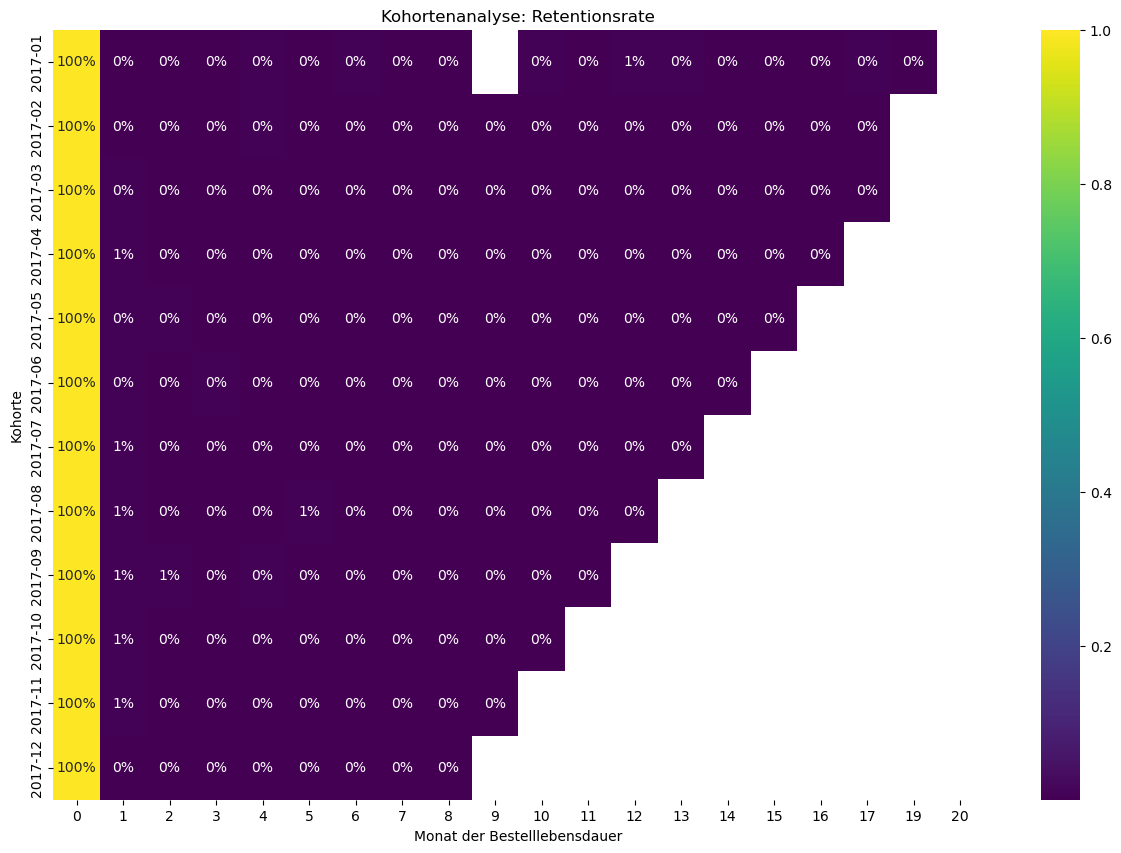

In [12]:
# Umwandlung der Spalte 'order_purchase_timestamp' in das Datetime-Format
abc['order_purchase_timestamp'] = pd.to_datetime(abc['order_purchase_timestamp'])

# Extraktion des Monats aus dem Datum
abc['purchase_month'] = abc['order_purchase_timestamp'].dt.to_period('M')

# Filtern der abgeschlossenen Bestellungen
completed_orders = abc[abc['order_status'] == 'delivered'].copy()

# Bestimmung der Kohorte für jeden Benutzer (erster Kaufmonat)
completed_orders.loc[:, 'cohort'] = completed_orders.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')

# Berechnung der Lebenszeit der Bestellung in Monaten relativ zur Kohorte
completed_orders.loc[:, 'order_lifetime'] = (completed_orders['purchase_month'] - completed_orders['cohort']).apply(lambda x: x.n)

# Gruppierung der Daten nach Kohorten und Lebenszeit der Bestellung und Zählen der eindeutigen Benutzer
cohort_data = completed_orders.groupby(['cohort', 'order_lifetime']).agg({'customer_unique_id': 'nunique'}).reset_index()

# Erstellung einer Pivot-Tabelle
cohort_pivot = cohort_data.pivot_table(index='cohort', columns='order_lifetime', values='customer_unique_id', aggfunc='first')

# Filtern der Kohorten von 2016 und 2018
cohort_pivot = cohort_pivot[(cohort_pivot.index.year != 2016) & (cohort_pivot.index.year != 2018)]

# Berechnung der Kohortengröße (Anzahl der eindeutigen Benutzer im ersten Monat)
cohort_size = cohort_pivot.iloc[:, 0]

# Berechnung der Retentionsrate
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Bestimmung der Kohorte mit der höchsten Retentionsrate im 3. Monat
max_retention_cohort = retention_matrix[3].idxmax()
print("Kohorte mit der höchsten Retention im 3. Monat:", max_retention_cohort)

# Ausgabe der Pivot-Tabelle
print(retention_matrix)

# Erstellung einer Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(retention_matrix, annot=True, fmt=".0%", cmap="viridis")
plt.title("Kohortenanalyse: Retentionsrate")
plt.xlabel("Monat der Bestelllebensdauer")
plt.ylabel("Kohorte")
plt.show()

In [13]:
# Überprüfung der Anzahl der abgeschlossenen Bestellungen
print("Anzahl der abgeschlossenen Bestellungen:", completed_orders.shape[0])

# Überprüfung der einzigartigen Werte in 'order_status'
print("Einzigartige Werte in 'order_status':", abc['order_status'].unique())

# Überprüfung des Datumsbereichs
print("Minimales Datum:", abc['order_purchase_timestamp'].min())
print("Maximales Datum:", abc['order_purchase_timestamp'].max())

# Überprüfung fehlender Werte
print("Fehlende Werte in 'order_id':", completed_orders['order_id'].isnull().sum())
print("Fehlende Werte in 'purchase_month':", completed_orders['purchase_month'].isnull().sum())

Anzahl der abgeschlossenen Bestellungen: 110197
Einzigartige Werte in 'order_status': ['delivered' 'invoiced' 'shipped' 'processing' 'canceled' 'unavailable'
 'approved']
Minimales Datum: 2016-09-04 21:15:19
Maximales Datum: 2018-09-03 09:06:57
Fehlende Werte in 'order_id': 0
Fehlende Werte in 'purchase_month': 0


## 6.RFM-Segmentierung von Benutzern zur qualitativen Bewertung der Zielgruppe

Ergebnisse der RFM-Analyse mit Clusterbildung:
       recency  frequency  monetary                customer_unique_id  cluster
0       2270.0        1.0    129.90  0000366f3b9a7992bf8c76cfdf3221e2        1
1       2277.0        1.0     18.90  0000b849f77a49e4a4ce2b2a4ca5be3f        1
2       2677.0        1.0     69.00  0000f46a3911fa3c0805444483337064        1
3       2466.0        1.0     25.99  0000f6ccb0745a6a4b88665a16c9f078        1
4       2440.0        1.0    180.00  0004aac84e0df4da2b147fca70cf8255        1
...        ...        ...       ...                               ...      ...
95415   2585.0        1.0   1570.00  fffcf5a5ff07b0908bd4e2dbc735a684        0
95416   2397.0        1.0     64.89  fffea47cd6d3cc0a88bd621562a9d061        1
95417   2719.0        1.0     89.90  ffff371b4d645b6ecea244b27531430a        1
95418   2273.0        1.0    115.00  ffff5962728ec6157033ef9805bacc48        1
95419   2642.0        1.0     56.99  ffffd2657e2aad2907e67c3e9daecbeb        1

[954

<Figure size 1200x800 with 0 Axes>

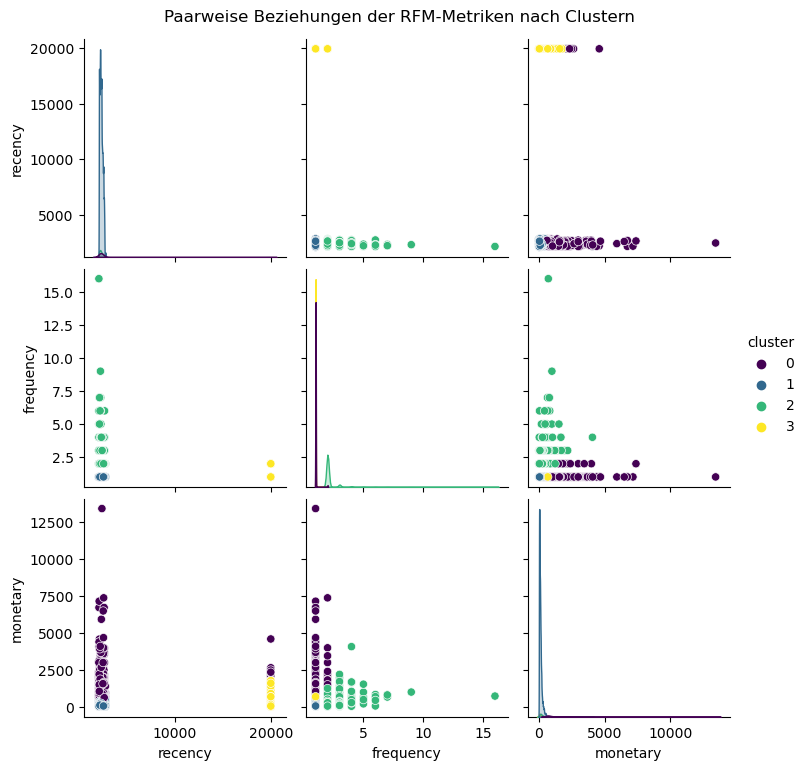

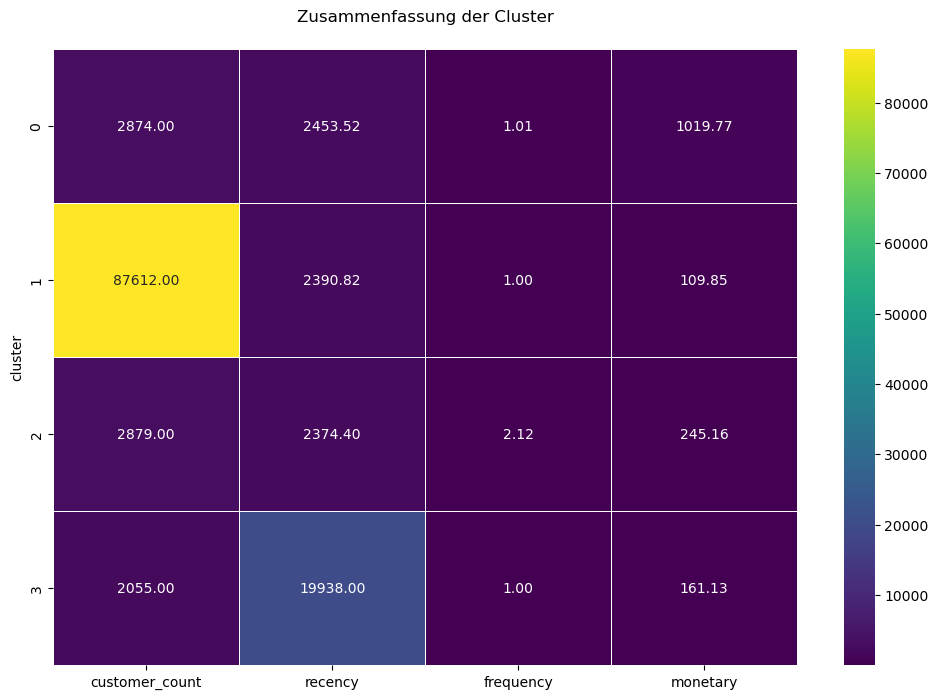


Cluster 0:
Anzahl der Kunden: 2874
Durchschnittlicher Recency: 2453.52 Tage
Durchschnittliche Frequency: 1.01
Durchschnittliche Monetary: 1019.77

Cluster 1:
Anzahl der Kunden: 87612
Durchschnittlicher Recency: 2390.82 Tage
Durchschnittliche Frequency: 1.00
Durchschnittliche Monetary: 109.85

Cluster 2:
Anzahl der Kunden: 2879
Durchschnittlicher Recency: 2374.40 Tage
Durchschnittliche Frequency: 2.12
Durchschnittliche Monetary: 245.16

Cluster 3:
Anzahl der Kunden: 2055
Durchschnittlicher Recency: 19938.00 Tage
Durchschnittliche Frequency: 1.00
Durchschnittliche Monetary: 161.13


In [14]:
# Set the environment variable for joblib (optional)
os.environ['LOKY_MAX_CPU_COUNT'] = '2'  # Set the number of cores you need

# Umwandlung der Spalten in das Datetime-Format
abc['order_delivered_customer_date'] = pd.to_datetime(abc['order_delivered_customer_date'])
abc['order_purchase_timestamp'] = pd.to_datetime(abc['order_purchase_timestamp'])

# Berechnung der Recency-Metrik
recency = (pd.to_datetime('now') - abc.groupby('customer_unique_id')['order_delivered_customer_date'].max()).dt.days

# Berechnung der Frequency-Metrik
frequency = abc.groupby('customer_unique_id')['order_id'].nunique()

# Berechnung der Monetary-Metrik
monetary = abc.groupby('customer_unique_id')['price'].sum()

# Erstellung eines DataFrames mit den RFM-Metriken
rfm_data = pd.DataFrame({'recency': recency, 'frequency': frequency, 'monetary': monetary})

# Imputation fehlender Werte mit dem Durchschnitt
imputer = SimpleImputer(strategy='mean')
rfm_data_imputed = pd.DataFrame(imputer.fit_transform(rfm_data), columns=rfm_data.columns)

# Skalierung der Daten
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data_imputed)

# Anwendung von K-means zur Clusterbildung
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

# Hinzufügen der Clusterergebnisse zu den Daten
rfm_data_imputed['customer_unique_id'] = rfm_data.index
rfm_data_imputed['cluster'] = kmeans.labels_

# Ausgabe der Ergebnisse der RFM-Analyse mit Clusterbildung
print("Ergebnisse der RFM-Analyse mit Clusterbildung:")
print(rfm_data_imputed)

# Erstellung einer Zusammenfassung der Cluster
cluster_summary = rfm_data_imputed.groupby('cluster').agg({
    'customer_unique_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).rename(columns={'customer_unique_id': 'customer_count'})

print("\nZusammenfassung der Cluster:")
print(cluster_summary)

# Visualisierung der paarweisen Beziehungen
plt.figure(figsize=(12, 8))
pairplot = sns.pairplot(rfm_data_imputed, hue='cluster', palette='viridis')
pairplot.fig.suptitle('Paarweise Beziehungen der RFM-Metriken nach Clustern', y=1.02)

# Entfernen des Aufrufs von tight_layout() in seaborn
plt.show()

# Visualisierung der Heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(cluster_summary, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
heatmap.set_title('Zusammenfassung der Cluster', pad=20)
plt.show()

# Analyse jedes Clusters
for cluster in cluster_summary.index:
    print(f"\nCluster {cluster}:")
    print(f"Anzahl der Kunden: {cluster_summary.loc[cluster, 'customer_count']}")
    print(f"Durchschnittlicher Recency: {cluster_summary.loc[cluster, 'recency']:.2f} Tage")
    print(f"Durchschnittliche Frequency: {cluster_summary.loc[cluster, 'frequency']:.2f}")
    print(f"Durchschnittliche Monetary: {cluster_summary.loc[cluster, 'monetary']:.2f}")
